# MMRotate Image Detection on Drone Imagery

Author: Kirsty Weitzel

## Import Libraries
conda environment path: /gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2

In [2]:
import pandas
import matplotlib.pyplot as plt

In [3]:
!pwd

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01


In [4]:
from mmcv.utils import collect_env

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [5]:
import mmrotate
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset
print(mmrotate.__version__)

0.3.4


In [6]:
# Test mmrotate installation
!mim download mmrotate --config oriented_rcnn_r50_fpn_1x_dota_le90 --dest .

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01


In [7]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

2.28.2


In [8]:
# Check mmcv installation
import mmcv
from mmcv import Config
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

10.2
GCC 7.3


In [9]:
import torch
print(torch.__version__)

1.8.0


In [10]:
from mmcv.utils import collect_env
collect_env()

/bin/sh: gcc: command not found


{'sys.platform': 'linux',
 'Python': '3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla V100-SXM2-16GB',
 'CUDA_HOME': '/gpfs/share/apps/cuda/10.1.105',
 'NVCC': 'Cuda compilation tools, release 10.1, V10.1.10',
 'GCC': 'n/a',
 'PyTorch': '1.8.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v1.7.0 (Git Hash 7aed236906b1f7a05c0917e5257a1af05e9ff683)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 10.2\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37\n  - CuDNN 

## Explore Data

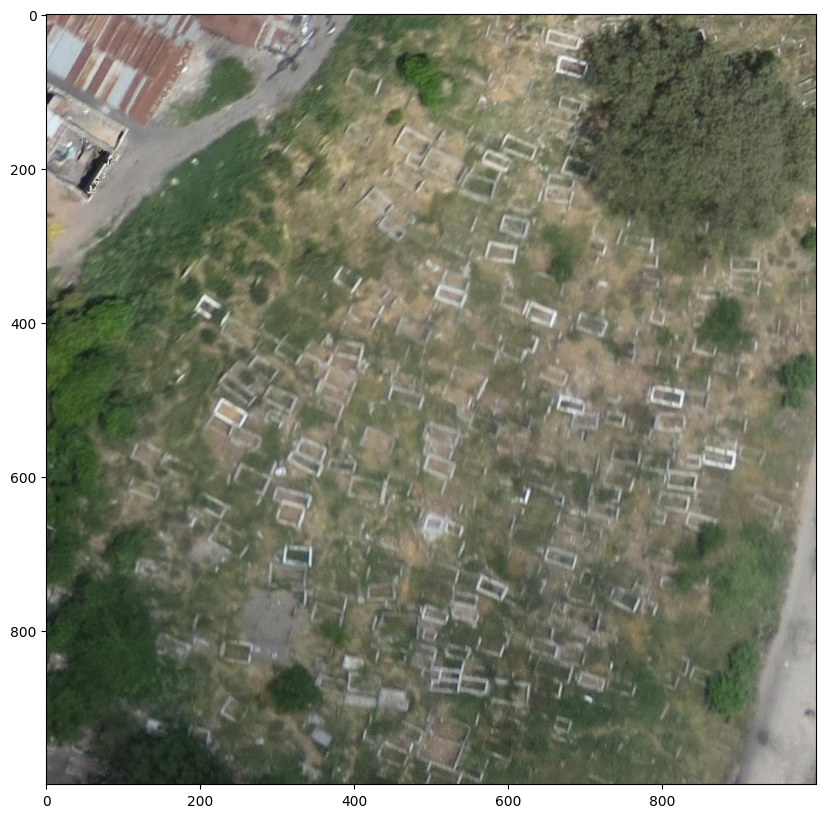

In [11]:
# Let's take a look at the dataset image
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [12]:
# Read in dataset labels as a dataframe
import pandas as pd
img_labels = pd.read_csv('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/train/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.txt',
            sep=' ',
            names=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label', 'difficulty'])
img_labels.head()

x1     y1     x2     y2     x3     y3     x4     y4  label  difficulty
0  652.9   17.7  648.9   32.4  690.2   47.1  694.2   31.1  grave           0
1  664.6   54.3  660.6   68.9  701.9   83.6  705.9   67.6  grave           0
2  395.3   74.3  391.3   88.9  432.6  103.6  436.6   87.6  grave           0
3  660.6  102.3  656.6  116.9  697.9  131.6  701.9  115.6  grave           0
4  597.9  159.6  593.9  174.3  635.3  188.9  639.3  172.9  grave           0

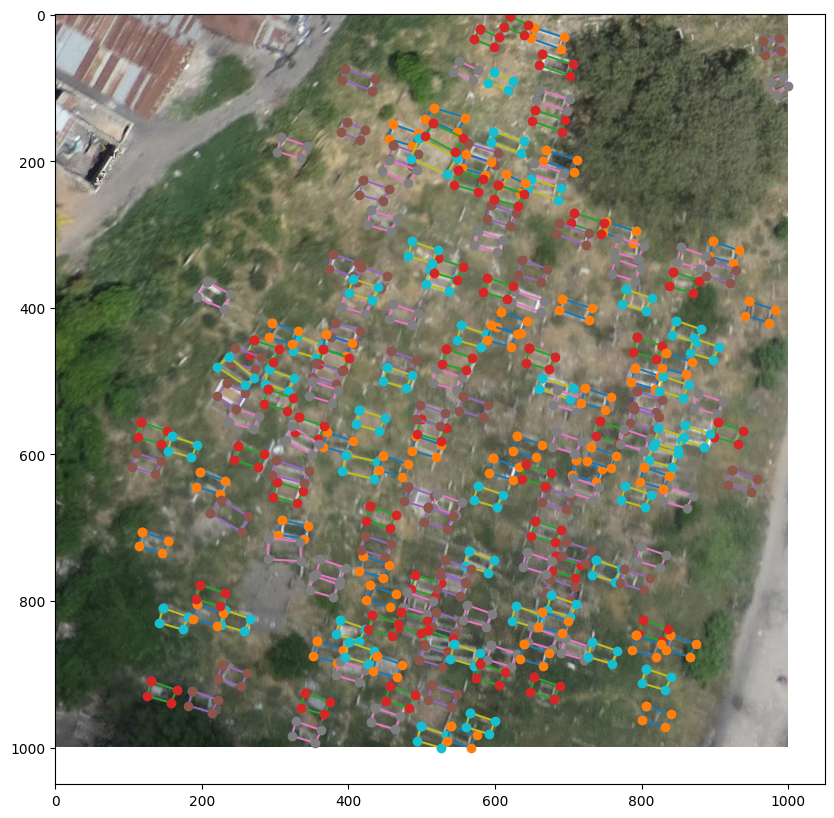

In [13]:
# Let's take a look at the dataset image with overlayed labels
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/DAR_UNLABLED_4_SatelliteImagery_drone_556f7a49ac00a903002fb01e.tif_0_0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
for index, row in img_labels.iterrows():
    x = row[['x1', 'x2', 'x3', 'x4', 'x1']]
    y = row[['y1', 'y2', 'y3', 'y4', 'y1']]
    plt.plot(x, y, '-')
    plt.plot(x, y, 'o')
plt.show()

## Create MMRotate config

In [14]:
@ROTATED_DATASETS.register_module()
class DroneDataset(DOTADataset):
    """Grave dataset for detection."""
    CLASSES = ('grave',)

In [15]:
# We use mim to download the pre-trained checkpoints for inference and finetuning.
!mim download mmrotate --config oriented_rcnn_r50_fpn_1x_dota_le90 --dest .

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing oriented_rcnn_r50_fpn_1x_dota_le90...
oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth exists in /gpfs/data/bershteynlab/SatelliteImagery/weitzk01
Successfully dumped oriented_rcnn_r50_fpn_1x_dota_le90.py to /gpfs/data/bershteynlab/SatelliteImagery/weitzk01


In [16]:
from mmcv import Config
cfg = Config.fromfile('oriented_rcnn_r50_fpn_1x_dota_le90.py')

In [17]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'DroneDataset'
cfg.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data'

cfg.data.test.type = 'DroneDataset'
cfg.data.test.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'DroneDataset'
cfg.data.train.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'DroneDataset'
cfg.data.val.data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model
cfg.load_from = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.001
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 200
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DroneDataset'
data_root = '/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='

## Train MMRotate Model

In [18]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
2024-05-13 12:15:17,583 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-05-13 12:15:18,158 - mmdet - INFO - load checkpoint from local path: oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
2024-05-13 12:15:18,434 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([2]).
2024-05-13 12:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:16:24,486 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 7360 | 0.709  | 0.661 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.661 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:17:29,112 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6531 | 0.719  | 0.675 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.675 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:18:32,141 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6280 | 0.752  | 0.695 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.695 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:19:35,067 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6085 | 0.750  | 0.698 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.698 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:20:35,418 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6143 | 0.753  | 0.698 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.698 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:21:35,379 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6164 | 0.754  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:22:33,622 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6197 | 0.756  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:23:32,749 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6197 | 0.756  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:23:32,827 - mmdet - INFO - Epoch(val) [24][46]	mAP: 0.6990
2024-05-13 12:23:38,715 - mmdet - INFO - Epoch [25][10/40]	lr: 1.000e-05, eta: 0:41:53, time: 0.588, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:24:32,505 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6197 | 0.756  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:25:33,056 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6193 | 0.757  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:26:31,779 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6163 | 0.756  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:26:31,855 - mmdet - INFO - Epoch(val) [33][46]	mAP: 0.6990
2024-05-13 12:26:37,672 - mmdet - INFO - Epoch [34][10/40]	lr: 1.000e-05, eta: 0:39:46, time: 0.581, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:27:31,035 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6167 | 0.757  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:28:28,784 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6187 | 0.758  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:29:27,648 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6189 | 0.757  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:30:24,643 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6173 | 0.758  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:30:24,707 - mmdet - INFO - Epoch(val) [45][46]	mAP: 0.6989
2024-05-13 12:30:30,503 - mmdet - INFO - Epoch [46][10/40]	lr: 1.000e-05, eta: 0:36:41, time: 0.578, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:31:23,073 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6161 | 0.758  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:31:23,131 - mmdet - INFO - Epoch(val) [48][46]	mAP: 0.6987
2024-05-13 12:31:28,727 - mmdet - INFO - Epoch [49][10/40]	lr: 1.000e-05, eta: 0:35:55, time: 0.559, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:32:21,407 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6145 | 0.758  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:33:21,230 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6152 | 0.758  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 12.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:34:19,230 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6168 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
2024-05-13 12:34:19,310 - mmdet - INFO - Epoch(val) [57][46]	mAP: 0.6990
2024-05-13 12:34:25,081 - mmdet - INFO - Epoch [58][10/40]	lr: 1.000e-05, eta: 0:33:47, time: 0.576, data_time: 0.312, memory: 4822, loss_rpn_cls: 0.0737, loss_rpn_bbox: 0.2016, loss_cls: 0.2954, acc: 87.6660, loss_bbox: 0.3559, loss: 0.9267, grad_norm: 3.6535
2024-05-13 12:34:27,857 - mmdet - INFO - Epoch [58][20/40]	lr: 1.000e-05, eta: 0:33:41, time: 0.278, data_time: 0.008, memory: 4822, loss_rpn_cls: 0.0718, loss_rpn_bbox: 0.1679, loss_cls: 0.2550, acc: 89.2090, loss_bbox: 0.3082, loss: 0.8029, grad_norm: 3.2501
2024-05-13 12:34:30,472 - mmdet - INFO - Epoch [58][30/40]	lr: 1.000e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:35:17,487 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6152 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:36:14,498 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6152 | 0.760  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.7 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:37:14,355 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6147 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:38:13,662 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6141 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:38:13,714 - mmdet - INFO - Epoch(val) [69][46]	mAP: 0.6989
2024-05-13 12:38:19,664 - mmdet - INFO - Epoch [70][10/40]	lr: 1.000e-05, eta: 0:30:57, time: 0.594, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:39:11,860 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6127 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.7 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:40:10,135 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6125 | 0.760  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:40:10,196 - mmdet - INFO - Epoch(val) [75][46]	mAP: 0.6989
2024-05-13 12:40:15,899 - mmdet - INFO - Epoch [76][10/40]	lr: 1.000e-05, eta: 0:29:30, time: 0.569, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:41:09,079 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6132 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:42:07,267 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6128 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
2024-05-13 12:42:07,317 - mmdet - INFO - Epoch(val) [81][46]	mAP: 0.6989
2024-05-13 12:42:13,184 - mmdet - INFO - Epoch [82][10/40]	lr: 1.000e-05, eta: 0:28:05, time: 0.585, data_time: 0.296, memory: 4822, loss_rpn_cls: 0.0749, loss_rpn_bbox: 0.1990, loss_cls: 0.2638, acc: 88.5742, loss_bbox: 0.2838, loss: 0.8214, grad_norm: 3.2567
2024-05-13 12:42:15,952 - mmdet - INFO - Epoch [82][20/40]	lr: 1.000e-05, eta: 0:28:01, time: 0.277, data_time: 0.009, memory: 4822, loss_rpn_cls: 0.0588, loss_rpn_bbox: 0.1295, loss_cls: 0.2715, acc: 88.1934, loss_bbox: 0.3549, loss: 0.8147, grad_norm: 3.4667
2024-05-13 12:42:18,756 - mmdet - INFO - Epoch [82][30/40]	lr: 1.000e-05, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.7 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:43:05,068 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6131 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:44:04,374 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6105 | 0.759  | 0.699 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.699 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:45:02,642 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6117 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:45:59,500 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6109 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:46:56,611 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6088 | 0.759  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:47:55,941 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6123 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
2024-05-13 12:47:55,989 - mmdet - INFO - Epoch(val) [99][46]	mAP: 0.7000
2024-05-13 12:48:01,751 - mmdet - INFO - Epoch [100][10/40]	lr: 1.000e-05, eta: 0:23:45, time: 0.575, data_time: 0.301, memory: 4822, loss_rpn_cls: 0.0963, loss_rpn_bbox: 0.1711, loss_cls: 0.2708, acc: 88.2227, loss_bbox: 0.3294, loss: 0.8676, grad_norm: 3.8839
2024-05-13 12:48:04,546 - mmdet - INFO - Epoch [100][20/40]	lr: 1.000e-05, eta: 0:23:41, time: 0.280, data_time: 0.008, memory: 4822, loss_rpn_cls: 0.0723, loss_rpn_bbox: 0.1590, loss_cls: 0.2540, acc: 89.2871, loss_bbox: 0.3012, loss: 0.7865, grad_norm: 3.1114
2024-05-13 12:48:07,274 - mmdet - INFO - Epoch [100][30/40]	lr: 1.000e-05,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:48:53,855 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6114 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.4 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:49:53,057 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6109 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:50:52,932 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6073 | 0.759  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:50:52,989 - mmdet - INFO - Epoch(val) [108][46]	mAP: 0.6999
2024-05-13 12:50:58,697 - mmdet - INFO - Epoch [109][10/40]	lr: 1.000e-05, eta: 0:21:39, time: 0.569, data_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:51:51,162 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6095 | 0.759  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.4 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:52:49,705 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6101 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.8 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:53:46,832 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6125 | 0.762  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:54:43,838 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6085 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:55:43,431 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6076 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 12:55:43,500 - mmdet - INFO - Epoch(val) [123][46]	mAP: 0.7002
2024-05-13 12:55:49,195 - mmdet - INFO - Epoch [124][10/40]	lr: 1.000e-05, eta: 0:18:04, time: 0.568, data_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.4 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:56:40,215 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6066 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:57:37,704 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6067 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:58:36,166 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6076 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.4 task/s, elapsed: 4s, ETA:     0s

2024-05-13 12:59:34,524 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6072 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:00:34,170 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6032 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
2024-05-13 13:00:34,241 - mmdet - INFO - Epoch(val) [138][46]	mAP: 0.7003
2024-05-13 13:00:40,050 - mmdet - INFO - Epoch [139][10/40]	lr: 1.000e-05, eta: 0:14:31, time: 0.580, data_time: 0.302, memory: 4822, loss_rpn_cls: 0.0753, loss_rpn_bbox: 0.1822, loss_cls: 0.2731, acc: 88.3887, loss_bbox: 0.3399, loss: 0.8705, grad_norm: 3.7545
2024-05-13 13:00:42,859 - mmdet - INFO - Epoch [139][20/40]	lr: 1.000e-05, eta: 0:14:27, time: 0.281, data_time: 0.008, memory: 4822, loss_rpn_cls: 0.0582, loss_rpn_bbox: 0.1416, loss_cls: 0.2735, acc: 87.9492, loss_bbox: 0.3140, loss: 0.7873, grad_norm: 3.3752
2024-05-13 13:00:45,730 - mmdet - INFO - Epoch [139][30/40]	lr: 1.000e-05

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:01:32,414 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6032 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 13:01:32,490 - mmdet - INFO - Epoch(val) [141][46]	mAP: 0.7003
2024-05-13 13:01:38,284 - mmdet - INFO - Epoch [142][10/40]	lr: 1.000e-05, eta: 0:13:49, time: 0.578, data_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:02:30,036 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6048 | 0.760  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:03:28,670 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6048 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:04:28,863 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6058 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:05:28,562 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6056 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:06:26,947 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6047 | 0.761  | 0.700 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.700 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.4 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:07:26,373 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6058 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:08:26,172 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6056 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:09:25,226 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6032 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:10:24,093 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6037 | 0.761  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2024-05-13 13:10:24,139 - mmdet - INFO - Epoch(val) [168][46]	mAP: 0.7009
2024-05-13 13:10:30,091 - mmdet - INFO - Epoch [169][10/40]	lr: 1.000e-05, eta: 0:07:28, time: 0.594, data_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.2 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:11:23,264 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6034 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:12:21,385 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6027 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 10.9 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:13:19,816 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6004 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.3 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:14:17,980 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 5978 | 0.761  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 12.0 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:15:15,459 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 5991 | 0.761  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.6 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:16:14,091 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6007 | 0.763  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:17:13,306 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6005 | 0.762  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:18:13,202 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 5983 | 0.763  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.5 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:19:12,828 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 6013 | 0.764  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 46/46, 11.1 task/s, elapsed: 4s, ETA:     0s

2024-05-13 13:20:11,400 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| grave | 4705 | 5980 | 0.763  | 0.701 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.701 |
+-------+------+------+--------+-------+
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2

## Apply Model to single image

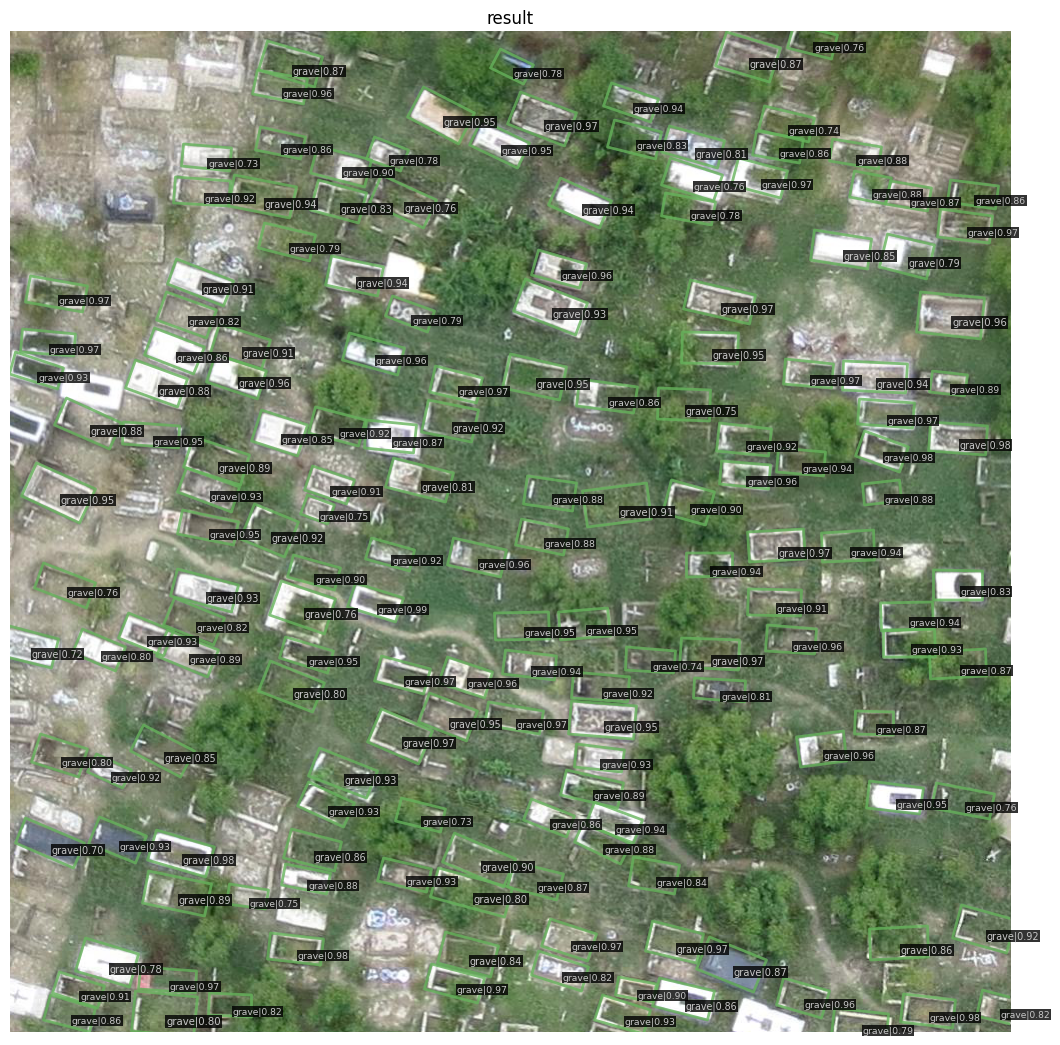

In [19]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/Mianzini Graveyard_SatelliteImagery_drone_556f7a4bac00a903002fb2a2.tif_3_5.png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.7)

## Calculate MAPE based on grave counts

### Calculate MAPE on single image

In [60]:
# Convert accuracy to grave counts over a threshold of .3 confidence on one image:

In [61]:
import numpy as np
confidence_threshold = .3
img_stem = 'Mianzini Graveyard_SatelliteImagery_drone_556f7a4bac00a903002fb2a2.tif_3_5'
img = mmcv.imread(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/{img_stem}.png')
img_labels = pd.read_csv(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/val/{img_stem}.txt',
            sep=' ',
            names=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label', 'difficulty'])
result = inference_detector(model, img)
no_graves_detected = len(np.where(result[0][:, -1] > confidence_threshold)[0])
no_graves_labeled = img_labels.shape[0]
print(f"Number of graves detected: {no_graves_detected}")
print(f"Number of graves labeled: {no_graves_labeled}")

Number of graves detected: 212
Number of graves labeled: 299


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


In [23]:
def get_number_of_graves_labeled(file_name, folder_name='val'):
    img_labels = pd.read_csv(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/{folder_name}/{file_name}.txt',
            sep=' ',
            names=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label', 'difficulty'])
    num_graves_labeled = img_labels.shape[0]
    return num_graves_labeled

def get_number_of_graves_detected(file_name, confidence_threshold=.3):
    img = mmcv.imread(f'/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/images/{img_stem}.png')
    result = inference_detector(model, img)
    num_graves_detected = len(np.where(result[0][:, -1] > confidence_threshold)[0])
    return num_graves_detected


### Calculate MAPE scores at various confidence thresholds

In [67]:
import os
import mmcv
from mmdet.apis import inference_detector
import numpy as np
import pandas as pd
import warnings

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [64]:
# Iterate through folder and get number of graves detected and labeled in pandas dataframe

# MMRotate has some deprecated functions causing multiple warnings - use this to only see warnings once
warnings.filterwarnings(action='once')

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

confidence_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

mapes = []
results = []

for confidence_threshold in confidence_list:

    for file_name in os.listdir('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/val'):
        img_stem = file_name.replace(".txt", "")
        num_graves_labeled = get_number_of_graves_detected(img_stem, confidence_threshold)
        num_graves_detected = get_number_of_graves_labeled(img_stem)
        
        results.append({'file_name': img_stem, 'num_graves_labeled': num_graves_labeled, 'num_graves_detected': num_graves_detected})
        
    results_df = pd.DataFrame(results)
    
    results_df['pct_detected'] = results_df['num_graves_detected'] / results_df['num_graves_labeled']
    results_df.sort_values("pct_detected", ascending=False)
    
    mape = MAPE(results_df['num_graves_labeled'], results_df['num_graves_detected'])
    mapes.append({'confidence_threshold': confidence_threshold, 'mape': mape})
    print(f'Confidence threshold: {confidence_threshold}, MAPE: {mape}')

mape_df = pd.DataFrame(mapes)

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.1, MAPE: 35.11245139854569


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.2, MAPE: 31.776192435901613


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.3, MAPE: 29.776621809879185


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.4, MAPE: 29.54388115508501


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.5, MAPE: 30.360595576725323


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.6, MAPE: 33.31436073619419


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.7, MAPE: 38.62066099916612


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.8, MAPE: 47.90180706504366


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

Confidence threshold: 0.9, MAPE: inf


/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


confidence_threshold       mape
0                   0.1  35.112451
1                   0.2  31.776192
2                   0.3  29.776622
3                   0.4  29.543881
4                   0.5  30.360596
5                   0.6  33.314361
6                   0.7  38.620661
7                   0.8  47.901807
8                   0.9        inf

In [66]:
mape_df

confidence_threshold       mape
0                   0.1  35.112451
1                   0.2  31.776192
2                   0.3  29.776622
3                   0.4  29.543881
4                   0.5  30.360596
5                   0.6  33.314361
6                   0.7  38.620661
7                   0.8  47.901807
8                   0.9        inf

### Get MAPE grouped by cemetary

In [54]:
import os
import mmcv
from mmdet.apis import inference_detector
import numpy as np
import pandas as pd

results = []

confidence_threshold = 0.5

for file_name in os.listdir('/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/drone_data/val'):
    img_stem = file_name.replace(".txt", "")
    num_graves_labeled = get_number_of_graves_detected(img_stem, confidence_threshold)
    num_graves_detected = get_number_of_graves_labeled(img_stem)
    
    results.append({'file_name': img_stem, 'num_graves_labeled': num_graves_labeled, 'num_graves_detected': num_graves_detected})
    
results_df = pd.DataFrame(results)

results_df['pct_error'] = np.abs(results_df['num_graves_labeled'] - results_df['num_graves_detected'])/results_df['num_graves_labeled']
results_df.sort_values("pct_error", ascending=False)

/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/SatelliteImagery/weitzk01/.conda/mmrotate_conda_env_v2/lib/python3.8/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '
/gpfs/data/bershteynlab/S

file_name  num_graves_labeled  \
40  Mianzini Graveyard_SatelliteImagery_drone_556f...                  33   
9   Mburahati Cemetery_SatelliteImagery_drone_556f...                  12   
24  Mburahati Cemetery_SatelliteImagery_drone_556f...                  10   
29  Mianzini Graveyard_SatelliteImagery_drone_556f...                  32   
18  Mianzini Graveyard_SatelliteImagery_drone_556f...                  50   
8   Mianzini Graveyard_SatelliteImagery_drone_556f...                 171   
26  Mianzini Graveyard_SatelliteImagery_drone_556f...                  35   
13  Mianzini Graveyard_SatelliteImagery_drone_556f...                 119   
0   Mianzini Graveyard_SatelliteImagery_drone_556f...                 198   
19  Mianzini Graveyard_SatelliteImagery_drone_556f...                 197   
1   Mianzini Graveyard_SatelliteImagery_drone_556f...                 162   
21  Mianzini Graveyard_SatelliteImagery_drone_556f...                  11   
37  Mikocheni A Cemetery_SatelliteImagery_drone_55...                 158   
33  Mianzini Graveyard_SatelliteImagery_drone_556f...                  49   
44  Mianzini Graveyard_SatelliteImagery_drone_556f...                  44   
12  Mianzini Graveyard_SatelliteImagery_drone_556f...                  20   
20  Mianzini Graveyard_SatelliteImagery_drone_556f...                 191   
4   Mianzini Graveyard_SatelliteImagery_drone_556f...                 226   
6   Mianzini Graveyard_SatelliteImagery_drone_556f...                  80   
3   Mianzini Graveyard_SatelliteImagery_drone_556f...                  80   
17  Mianzini Graveyard_SatelliteImagery_drone_556f...                  78   
31  Mianzini Graveyard_SatelliteImagery_drone_556f...                  15   
39  Mianzini Graveyard_SatelliteImagery_drone_556f...                 143   
45  Mianzini Graveyard_SatelliteImagery_drone_556f...                 131   
30  Mianzini Graveyard_SatelliteImagery_drone_556f...                 160   
10  Mikocheni A Cemetery_SatelliteImagery_drone_55...                 133   
43  Mburahati Cemetery_SatelliteImagery_drone_556f...                  14   
22  Mianzini Graveyard_SatelliteImagery_drone_556f...                  29   
35  Mikocheni A Cemetery_SatelliteImagery_drone_55...                  87   
28  Karume Cemetery_SatelliteImagery_drone_556f7a4...                  31   
14  Mianzini Graveyard_SatelliteImagery_drone_556f...                  28   
23  Mikocheni A Cemetery_SatelliteImagery_drone_55...                  34   
41  Mburahati Cemetery_SatelliteImagery_drone_556f...                  17   
34  Mianzini Graveyard_SatelliteImagery_drone_556f...                  57   
38  Mianzini Graveyard_SatelliteImagery_drone_556f...                  80   
25  Mianzini Graveyard_SatelliteImagery_drone_556f...                  79   
27  Mikocheni A Cemetery_SatelliteImagery_drone_55...                 130   
5   Mianzini Graveyard_SatelliteImagery_drone_556f...                  35   
36  Mianzini Graveyard_SatelliteImagery_drone_556f...                  91   
11  Karume Cemetery_SatelliteImagery_drone_556f7a4...                  73   
7   Karume Cemetery_SatelliteImagery_drone_556f7a4...                  11   
42  Mikocheni A Cemetery_SatelliteImagery_drone_55...                  49   
32  Mikocheni A Cemetery_SatelliteImagery_drone_55...                 123   
15  Mburahati Cemetery_SatelliteImagery_drone_556f...                  13   
2   Mikocheni A Cemetery_SatelliteImagery_drone_55...                  36   
16  Mburahati Cemetery_SatelliteImagery_drone_556f...                  15   

    num_graves_detected  pct_error  
40                   81   1.454545  
9                     1   0.916667  
24                    2   0.800000  
29                   55   0.718750  
18                   85   0.700000  
8                   269   0.573099  
26                   53   0.514286  
13                  180   0.512605  
0                   299   0.510101  
19                  289   0.467005  
1                

In [56]:
results_df['Cemetary'] = results_df['file_name'].str.split('_').str[0]

In [57]:
cemetary_results = results_df.groupby('Cemetary').agg({"num_graves_labeled": sum, "num_graves_detected" :sum})
cemetary_results

num_graves_labeled  num_graves_detected
Cemetary                                                     
Karume Cemetery                      115                  128
Mburahati Cemetery                    81                   61
Mianzini Graveyard                  2624                 3624
Mikocheni A Cemetery                 750                  892

In [58]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(cemetary_results['num_graves_labeled'], cemetary_results['num_graves_detected'])

23.259698820418155

## Tensorboard

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps